In [1]:
# ----------------------
# Load required packages
# ----------------------
import copy
import gc
import sys, getopt
import ujson as json
import random
import emcee
import datetime
import corner
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing as mp
from multiprocessing import Pool
from covid19model.models import models
from covid19model.optimization.run_optimization import checkplots, calculate_R0
from covid19model.optimization.objective_fcns import prior_custom, prior_uniform
from covid19model.data import mobility, sciensano, model_parameters
from covid19model.optimization import pso, objective_fcns
from covid19model.models.time_dependant_parameter_fncs import ramp_fun
from covid19model.visualization.output import _apply_tick_locator 
from covid19model.visualization.optimization import autocorrelation_plot, traceplot
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
# ---------
# Load data
# ---------

# Contact matrices
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012')
Nc_all = {'total': Nc_total, 'home':Nc_home, 'work': Nc_work, 'schools': Nc_schools, 'transport': Nc_transport, 'leisure': Nc_leisure, 'others': Nc_others}
levels = initN.size
# Sciensano data
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
# Google Mobility data
df_google = mobility.get_google_mobility_data(update=False)
# Model initial condition on September 1st
warmup = 0
with open('../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/initial_states_2020-09-01.json', 'r') as fp:
    initial_states = json.load(fp)  
# Samples dictionary
with open('../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/BE_WAVE2_BETA_COMPLIANCE_2021-03-02.json', 'r') as fp:
    samples_dict = json.load(fp)

In [8]:
# --------------------------------------
# Time-dependant social contact function
# --------------------------------------

# Extract build contact matrix function
from covid19model.models.time_dependant_parameter_fncs import make_contact_matrix_function, ramp_fun
contact_matrix_4prev, all_contact, all_contact_no_schools = make_contact_matrix_function(df_google, Nc_all)

# Define policy function
def policies_wave2(t, states, param, l , tau, prev_schools, prev_work, prev_rest, prev_home, scenario=0, contact_increase=1):
    
    # Convert tau and l to dates
    tau_days = pd.Timedelta(tau, unit='D')
    l_days = pd.Timedelta(l, unit='D')

    # Define key dates of first wave
    t1 = pd.Timestamp('2020-03-15') # start of lockdown
    t2 = pd.Timestamp('2020-05-15') # gradual re-opening of schools (assume 50% of nominal scenario)
    t3 = pd.Timestamp('2020-07-01') # start of summer holidays
    t4 = pd.Timestamp('2020-09-01') # end of summer holidays

    # Define key dates of second wave
    t5 = pd.Timestamp('2020-10-19') # lockdown (1)
    t6 = pd.Timestamp('2020-11-02') # lockdown (2)
    t7 = pd.Timestamp('2020-11-16') # schools re-open
    t8 = pd.Timestamp('2020-12-18') # Christmas holiday starts
    t9 = pd.Timestamp('2021-01-04') # Christmas holiday ends
    t10 = pd.Timestamp('2021-02-15') # Spring break starts
    t11 = pd.Timestamp('2021-02-21') # Spring break ends
    t12 = pd.Timestamp('2021-02-28') # Contact increase in children
    if scenario == 0:
        # Paasvakantie as is
        t13 = pd.Timestamp('2021-04-02') 
        t14 = pd.Timestamp('2021-04-18') 
    elif scenario == 1:
        # Extend one week before
        t13 = pd.Timestamp('2021-03-26') 
        t14 = pd.Timestamp('2021-04-18')
    elif scenario == 2:
        # Extend one week after
        t13 = pd.Timestamp('2021-04-02') 
        t14 = pd.Timestamp('2021-04-25')
    elif scenario == 3:
        # Shift one week
        t13 = pd.Timestamp('2021-03-26') 
        t14 = pd.Timestamp('2021-04-11')
    elif scenario == 4:
        # No easter holiday
        t13 = pd.Timestamp('2021-04-02') 
        t14 = pd.Timestamp('2021-04-02') 
    elif scenario == 5:
        # Close schools
        t13 = pd.Timestamp('2021-04-02') 
        t14 = pd.Timestamp('2021-06-30') 
        
    t15 = pd.Timestamp('2021-07-01') # Summer holiday starts

    t = pd.Timestamp(t.date())
    # First wave
    if t <= t1:
        return all_contact(t)
    elif t1 < t < t1 + tau_days:
        return all_contact(t)
    elif t1 + tau_days < t <= t1 + tau_days + l_days:
        policy_old = all_contact(t)
        policy_new = contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                    school=0)
        return ramp_fun(policy_old, policy_new, t, tau_days, l, t1)
    elif t1 + tau_days + l_days < t <= t2:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
    elif t2 < t <= t3:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
    elif t3 < t <= t4:
        return contact_matrix_4prev(t, school=0)
    # Second wave
    elif t4 < t <= t5 + tau_days:
        return contact_matrix_4prev(t, school=1)
    elif t5 + tau_days < t <= t5 + tau_days + l_days:
        policy_old = contact_matrix_4prev(t, school=1)
        policy_new = contact_matrix_4prev(t, prev_schools, prev_work, prev_rest, 
                                    school=1)
        return ramp_fun(policy_old, policy_new, t, tau_days, l, t5)
    elif t5 + tau_days + l_days < t <= t6:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=1)
    elif t6 < t <= t7:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
    elif t7 < t <= t8:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=1) 
    elif t8 < t <= t9:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
    elif t9 < t <= t10:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=1)
    elif t10 < t <= t11:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)    
    elif t11 < t <= t12:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=1)
    elif t12 < t <= t13:
        mat = contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, school=1)
        mat = np.array(mat)
        mat[:,0] = (contact_increase+1)*mat[:,0]
        mat[:,1] = (contact_increase+1)*mat[:,1]
        return mat
    elif t13 < t <= t14:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0) 
    elif t14 < t <= t15:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=1) 
    else:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)

# ------------------------------
# Function to add binomial draws
# ------------------------------

def add_poisson(state_name, output, n_samples, n_draws_per_sample, UL=1-0.05*0.5, LL=0.05*0.5):
    data = output[state_name].sum(dim="Nc").values
    # Initialize vectors
    vector = np.zeros((data.shape[1],n_draws_per_sample*n_samples))
    # Loop over dimension draws
    for n in range(data.shape[0]):
        binomial_draw = np.random.poisson( np.expand_dims(data[n,:],axis=1),size = (data.shape[1],n_draws_per_sample))
        vector[:,n*n_draws_per_sample:(n+1)*n_draws_per_sample] = binomial_draw
    # Compute mean and median
    mean = np.mean(vector,axis=1)
    median = np.median(vector,axis=1)    
    # Compute quantiles
    LL = np.quantile(vector, q = LL, axis = 1)
    UL = np.quantile(vector, q = UL, axis = 1)
    return mean, median, LL, UL

# -----------------------------------------
# Define sampling function with vaccination
# -----------------------------------------

def draw_fcn_vacc(param_dict,samples_dict):
    # Calibrated samples
    idx, param_dict['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    param_dict['da'] = samples_dict['da'][idx]
    param_dict['omega'] = samples_dict['omega'][idx]
    param_dict['sigma'] = 5.2 - samples_dict['omega'][idx]
    param_dict['tau'] = samples_dict['tau'][idx] 
    param_dict['l'] = samples_dict['l'][idx] 
    param_dict['prev_schools'] = samples_dict['prev_schools'][idx]   
    param_dict['prev_home'] = samples_dict['prev_home'][idx]      
    param_dict['prev_work'] = samples_dict['prev_work'][idx]       
    param_dict['prev_rest'] = samples_dict['prev_rest'][idx]
    # Vaccination parameters
    param_dict['e_i'] = np.random.uniform(low=0,high=1) # Vaccinated individual can either be non-infectious or equally infectious as a non-vaccinated individual 
    param_dict['e_s'] = np.random.uniform(low=0.85,high=0.95) # Vaccine results in a 85-95% lower susceptibility
    param_dict['e_h'] = np.random.uniform(low=0.5,high=1.0) # Vaccine blocks hospital admission between 50-100%
    param_dict['refusal'] = np.random.triangular(0.05, 0.20, 0.40, size=9) # min. refusal = 5%, max. refusal = 40%, expectation = 20%
    # Variant parameters
    param_dict['K_inf'] = np.random.uniform(low=1.25,high=1.40)
    return param_dict

In [4]:
# ----------------------------------------
# Initialize the model without vaccination
# ----------------------------------------

# Load the model parameters dictionary
params = model_parameters.get_COVID19_SEIRD_parameters()
params.update({'l': 21, 'tau': 21, 'prev_schools': 0, 'prev_work': 0.5, 'prev_rest': 0.5,
               'prev_home': 0.5, 'zeta': 8*30})

# -------------------------------------
# Initialize the model with vaccination
# -------------------------------------
from covid19model.models.time_dependant_parameter_fncs import  make_vaccination_function, vacc_strategy
sciensano_first_dose, df_sciensano_start, df_sciensano_end = make_vaccination_function(df_sciensano)

# Add states # TO DO: automatically do this
initial_states_vacc = copy.deepcopy(initial_states)
initial_states_vacc.update({'S_v': np.zeros(9), 'E_v': np.zeros(9), 'I_v': np.zeros(9),
                            'A_v': np.zeros(9), 'M_v': np.zeros(9), 'ER_v': np.zeros(9), 'C_v': np.zeros(9),
                            'C_icurec_v': np.zeros(9), 'ICU_v': np.zeros(9), 'R_v': np.zeros(9)})

# Add the time-dependant parameter function arguments
vacc_order = np.array(range(9))
vacc_order = vacc_order[::-1]
daily_dose = 30000
refusal = 0.3*np.ones(9)
delay = 21
d_vacc = 12*30 # duration of vaccine protection

params_vacc = model_parameters.get_COVID19_SEIRD_parameters(vaccination=True)
# Update with additional parameters for social policy function
params_vacc.update({'l': 21, 'tau': 21, 'prev_schools': 0, 'prev_work': 0.5, 'prev_rest': 0.5,
               'prev_home': 0.5, 'zeta': 8*30, 'contact_increase': 0})
# Update with additional parameters for vaccination
params_vacc.update(
    {'scenario': 0, 'vacc_order': vacc_order, 'daily_dose': daily_dose,
     'refusal': refusal, 'delay': delay, 'df_sciensano_start': df_sciensano_start,
     'df_sciensano_end': df_sciensano_end, 'sciensano_first_dose': sciensano_first_dose}
)

# Initialize model
model_vacc = models.COVID19_SEIRD_vacc(initial_states_vacc, params_vacc,
                        time_dependent_parameters={'Nc': policies_wave2, 'N_vacc': vacc_strategy})

In [5]:
# --------------------------
# Initialize the new variant
# --------------------------
start_sim = '2020-09-01'
K_inf = 1.30
K_hosp = 1.00
Re_1feb = 0.958*K_inf
incubation_period = 5.2
n_periods = 14/incubation_period

model_vacc.parameters.update({'K_inf': K_inf,
                              'K_hosp': K_hosp,
                              'injection_day': (pd.Timestamp('2021-01-14') - pd.Timestamp(start_sim))/pd.Timedelta('1D'),
                              'injection_ratio': (K_inf-1)/(Re_1feb**n_periods)})

In [9]:
# -----------------
# Scenario settings
# -----------------

contact_increases = [0,0.25]
scenarios = [0,1,2,3,4,5]
start_calibration = start_sim
end_calibration = '2021-02-01'
end_sim = '2021-09-01'
n_samples = 5
n_draws = 1
simulate = True
save = False

if simulate:
    # ---------------------------
    # Pre-allocation of dataframe
    # ---------------------------
    index = pd.date_range(start=start_sim, end=end_sim)
    columns = [
    ['0 %', '0 %','0 %','0 %','0 %','0 %','0 %','0 %','0 %','0 %','0 %','0 %','0 %','0 %','0 %',
        '20 %','20 %','20 %','20 %','20 %','20 %','20 %','20 %','20 %','20 %','20 %','20 %','20 %','20 %','20 %'],
    ['0','0','0','1','1','1','2','2','2','3','3','3','4','4','4',
         '0','0','0','1','1','1','2','2','2','3','3','3','4','4','4'],
    ['mean','LL','UL','mean','LL','UL','mean','LL','UL','mean','LL','UL','mean','LL','UL',
        'mean','LL','UL','mean','LL','UL','mean','LL','UL','mean','LL','UL','mean','LL','UL']
    ]
    tuples = list(zip(*columns))
    columns = pd.MultiIndex.from_tuples(tuples, names=["Contact increase in children", "School scenario", "Model output"])
    data = np.zeros([len(index),30])
    df_sim = pd.DataFrame(data=data, index=index, columns=columns)

    # -------------------
    # Perform simulations
    # -------------------
    for contact_increase in contact_increases:
        print('Contact increase in children set to '+str((contact_increase)*100) + ' %')
        model_vacc.parameters.update({'contact_increase': contact_increase})
        for idx,scenario in enumerate(scenarios):
            print('Simulating scenario '+str(scenario))
            model_vacc.parameters.update({'scenario': scenario})
            out_vacc = model_vacc.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn_vacc,samples=samples_dict)
            mean, median, LL, UL = add_poisson('H_in', out_vacc, n_samples, n_draws)
            df_sim[str(int(contact_increase*100))+' %', str(scenario), "mean"] = mean
            df_sim[str(int(contact_increase*100))+' %',str(scenario), "LL"] = LL
            df_sim[str(int(contact_increase*100))+' %',str(scenario), "UL"] = UL

    # --------------
    # Save dataframe
    # --------------
    if save:
        df_sim.to_csv('../../results/predictions/national/schools-easter-FVdB/simulations-schools-easter.csv')
    
else:
    df_sim = pd.read_csv('../../results/predictions/national/schools-easter-FVdB/simulations-schools-easter.csv', header=[0,1,2], index_col=0, parse_dates=True)

Contact increase in children set to 0 %
Simulating scenario 0
Simulating scenario 1
Simulating scenario 2
Simulating scenario 3
Simulating scenario 4
Simulating scenario 5
Contact increase in children set to 25.0 %
Simulating scenario 0
Simulating scenario 1
Simulating scenario 2
Simulating scenario 3
Simulating scenario 4
Simulating scenario 5


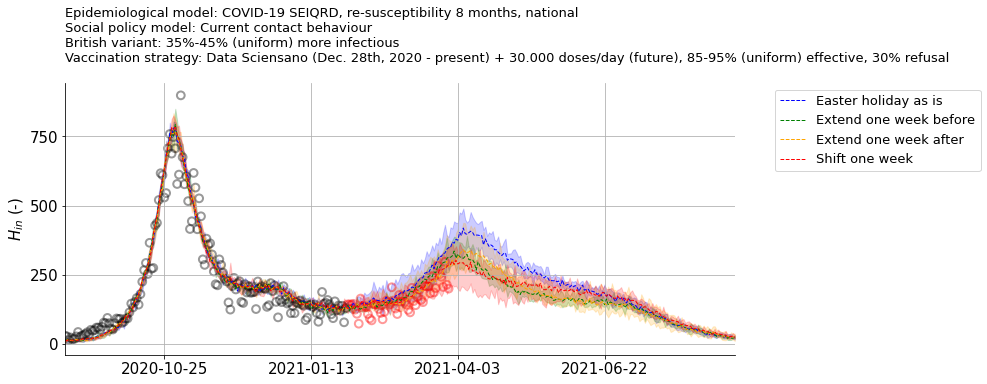

In [10]:
scenarios = [0,1,2,3]
colors = ['blue','green','orange','red']
fig,ax = plt.subplots(figsize=(12,5))
for idx,scenario in enumerate(scenarios):
    ax.plot(df_sim.index, df_sim['25 %', str(scenario), 'mean'],'--', color=colors[idx], linewidth=1)
    ax.fill_between(df_sim.index, df_sim['25 %', str(scenario), 'LL'], df_sim['25 %', str(scenario), 'UL'], alpha=0.20, color = colors[idx])

ax.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['H_in'][start_calibration:end_calibration], color='black', alpha=0.4, linestyle='None', facecolors='none', s=60, linewidth=2)
ax.scatter(df_sciensano[pd.to_datetime(end_calibration)+datetime.timedelta(days=1):end_sim].index,df_sciensano['H_in'][pd.to_datetime(end_calibration)+datetime.timedelta(days=1):end_sim], color='red', alpha=0.4, linestyle='None', facecolors='none', s=60, linewidth=2)

ax = _apply_tick_locator(ax)
ax.set_xlim('2020-09-01',end_sim)
ax.set_ylabel('$H_{in}$ (-)')
ax.set_title('Epidemiological model: COVID-19 SEIQRD, re-susceptibility 8 months, national\nSocial policy model: Current contact behaviour\nBritish variant: 35%-45% (uniform) more infectious\nVaccination strategy: Data Sciensano (Dec. 28th, 2020 - present) + 30.000 doses/day (future), 85-95% (uniform) effective, 30% refusal\n',loc='left',fontsize=13)
ax.legend(['Easter holiday as is','Extend one week before', 'Extend one week after','Shift one week'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13)

fig.savefig('../../results/predictions/national/schools-easter-FVdB/twallema-schools_0.pdf', dpi=400, bbox_inches='tight')
fig.savefig('../../results/predictions/national/schools-easter-FVdB/twallema-schools_0.jpg', dpi=400, bbox_inches='tight')

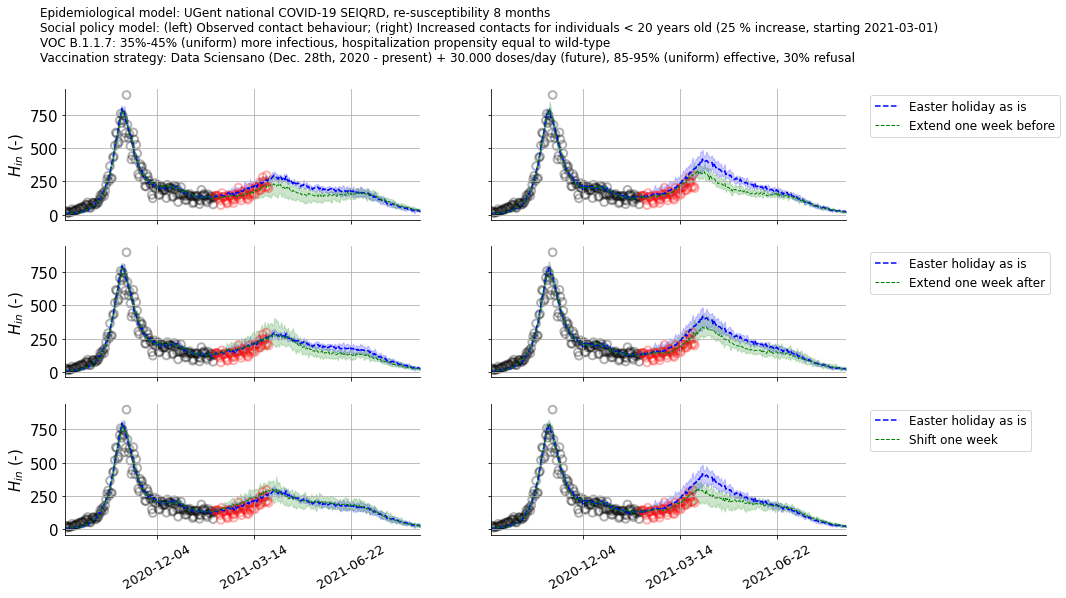

In [11]:
start_calibration = start_sim
end_calibration = '2021-02-01'
end_sim = '2021-09-01'

contact_increase = [0,0.25]
scenarios = [0,1,2,3]
legend_entries = ['Extend one week before', 'Extend one week after', 'Shift one week']
fig,axes = plt.subplots(ncols=2,nrows=3,figsize=(14,8.2), sharey=True, sharex=True)

# -------------------------------------
# Plot baseline scenario in every graph
# -------------------------------------

for idx,ax_row in enumerate(axes):
    for jdx,ax in enumerate(ax_row):
        ax.plot(df_sim.index, df_sim[str(int(contact_increase[jdx]*100))+' %',"0","mean"],'--', color='blue', linewidth=1.5)
        ax.fill_between(df_sim.index, df_sim[str(int(contact_increase[jdx]*100))+' %',"0","LL"], df_sim[str(int(contact_increase[jdx]*100))+' %',"0","UL"],alpha=0.20, color = 'blue')


for idx,scenario in enumerate(scenarios[1:]):

    # -----------
    # Add to plot
    # -----------
    ax_row = axes[idx]
    for jdx,ax in enumerate(ax_row):
        ax.plot(df_sim.index, df_sim[str(int(contact_increase[jdx]*100))+' %', str(scenario),"mean"], '--', color='green', linewidth=1)
        ax.fill_between(df_sim.index, df_sim[str(int(contact_increase[jdx]*100))+' %', str(scenario),"LL"], df_sim[str(int(contact_increase[jdx]*100))+' %', str(scenario),"UL"], alpha=0.20, color = 'green')

        ax.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['H_in'][start_calibration:end_calibration], color='black', alpha=0.3, linestyle='None', facecolors='none', s=60, linewidth=2)
        ax.scatter(df_sciensano[pd.to_datetime(end_calibration)+datetime.timedelta(days=1):end_sim].index,df_sciensano['H_in'][pd.to_datetime(end_calibration)+datetime.timedelta(days=1):end_sim], color='red', alpha=0.3, linestyle='None', facecolors='none', s=60, linewidth=2)

        ax = _apply_tick_locator(ax)
        ax.xaxis.set_major_locator(plt.MaxNLocator(4))
        ax.xaxis.set_tick_params(labelsize=13, rotation=30)
        ax.set_xlim('2020-09-01',end_sim)
        if jdx == 0:
            ax.set_ylabel('$H_{in}$ (-)')
        #if idx == 0:
            #column_titles=['Observed contact behaviour','20 % increase of contacts in ages [0, 20[\nstarting 2021-03-01']
            #ax.set_title(column_titles[jdx], fontsize=13)
    ax.legend(['Easter holiday as is',legend_entries[idx]], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

fig.suptitle('Epidemiological model: UGent national COVID-19 SEIQRD, re-susceptibility 8 months\nSocial policy model: (left) Observed contact behaviour; (right) Increased contacts for individuals < 20 years old (25 % increase, starting 2021-03-01)\nVOC B.1.1.7: 35%-45% (uniform) more infectious, hospitalization propensity equal to wild-type\nVaccination strategy: Data Sciensano (Dec. 28th, 2020 - present) + 30.000 doses/day (future), 85-95% (uniform) effective, 30% refusal\n', 
             x=0.1, y=1.02, ha='left', fontsize=12)
    
fig.savefig('../../results/predictions/national/schools-easter-FVdB/twallema-schools_3.pdf', dpi=400, bbox_inches='tight')
fig.savefig('../../results/predictions/national/schools-easter-FVdB/twallema-schools_3.jpg', dpi=400, bbox_inches='tight')

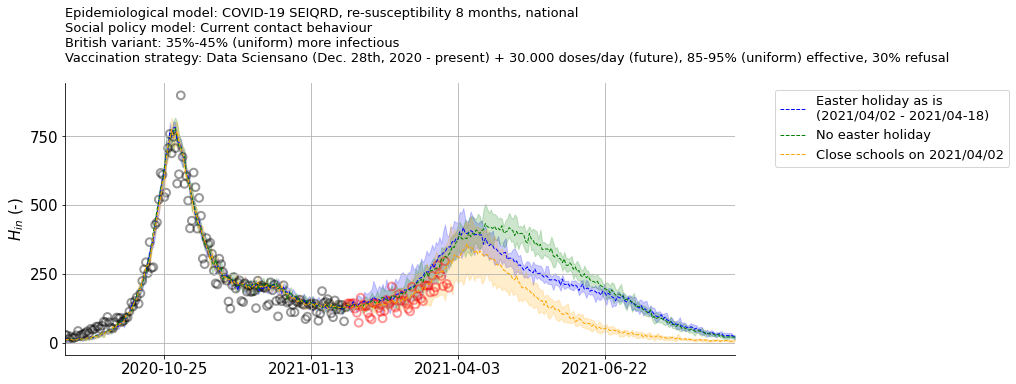

In [12]:
scenarios = [0,4,5]
colors = ['blue','green','orange']
fig,ax = plt.subplots(figsize=(12,5))
for idx,scenario in enumerate(scenarios):
    ax.plot(df_sim.index, df_sim['25 %', str(scenario),'mean'],'--', color=colors[idx], linewidth=1)
    ax.fill_between(df_sim.index, df_sim['25 %', str(scenario),'LL'], df_sim['25 %', str(scenario),'UL'],alpha=0.20, color = colors[idx])

ax.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['H_in'][start_calibration:end_calibration], color='black', alpha=0.4, linestyle='None', facecolors='none', s=60, linewidth=2)
ax.scatter(df_sciensano[pd.to_datetime(end_calibration)+datetime.timedelta(days=1):end_sim].index,df_sciensano['H_in'][pd.to_datetime(end_calibration)+datetime.timedelta(days=1):end_sim], color='red', alpha=0.4, linestyle='None', facecolors='none', s=60, linewidth=2)

ax = _apply_tick_locator(ax)
ax.set_xlim('2020-09-01',end_sim)
ax.set_ylabel('$H_{in}$ (-)')
ax.set_title('Epidemiological model: COVID-19 SEIQRD, re-susceptibility 8 months, national\nSocial policy model: Current contact behaviour\nBritish variant: 35%-45% (uniform) more infectious\nVaccination strategy: Data Sciensano (Dec. 28th, 2020 - present) + 30.000 doses/day (future), 85-95% (uniform) effective, 30% refusal\n',loc='left',fontsize=13)
ax.legend(['Easter holiday as is\n(2021/04/02 - 2021/04-18)','No easter holiday', 'Close schools on 2021/04/02'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13)

fig.savefig('../../results/predictions/national/schools-easter-FVdB/twallema-schools_2.pdf', dpi=400, bbox_inches='tight')
fig.savefig('../../results/predictions/national/schools-easter-FVdB/twallema-schools_2.jpg', dpi=400, bbox_inches='tight')